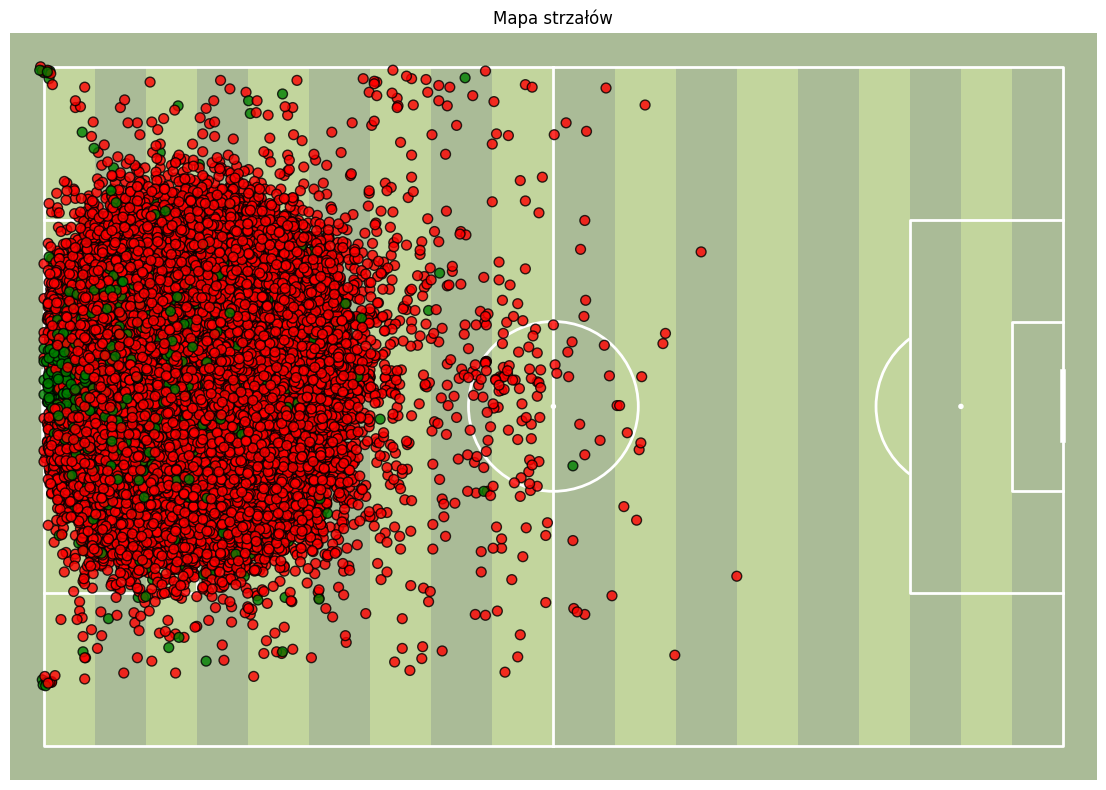

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch
from scipy.spatial import Voronoi
from matplotlib.collections import LineCollection
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np

# Przykładowe wczytanie danych (dostosuj ścieżkę lub sposób wczytania do swoich potrzeb)
df = pd.read_csv('data_to_ml.csv')

# Jeśli kolumna is_goal jest liczbowa (0/1), możemy ją przekonwertować na bool
df['is_goal'] = df['is_goal'].astype(bool)

# Definicja kolorów – gole na zielono, reszta na czerwono
colors = {True: 'green', False: 'red'}

# Możesz też zdecydować się na wizualizację przy użyciu innej zmiennej, np. strzały pod presją, technika, itp.

# Inicjalizacja boiska. Przyjmujemy, że współrzędne w danych są w skali od 0 do 100;
# jeśli masz inną skalę (np. 105 x 68), możesz podać parametry xlim i ylim w metodzie draw().
pitch = Pitch(pitch_color='#aabb97', line_color='white', stripe=True)
fig, ax = pitch.draw(figsize=(12, 8))  # Dostosuj rozmiar figury

# Rysowanie punktów – każdy punkt to lokalizacja strzału (x1, y1)
ax.scatter(df['x1'], df['y1'], 
           c=df['is_goal'].map(colors), 
           s=50,  # wielkość markerów – można skalować w zależności od innej zmiennej, np. xG
           alpha=0.8, 
           edgecolors='black',
           zorder=5)
plt.title("Mapa strzałów")
plt.show()


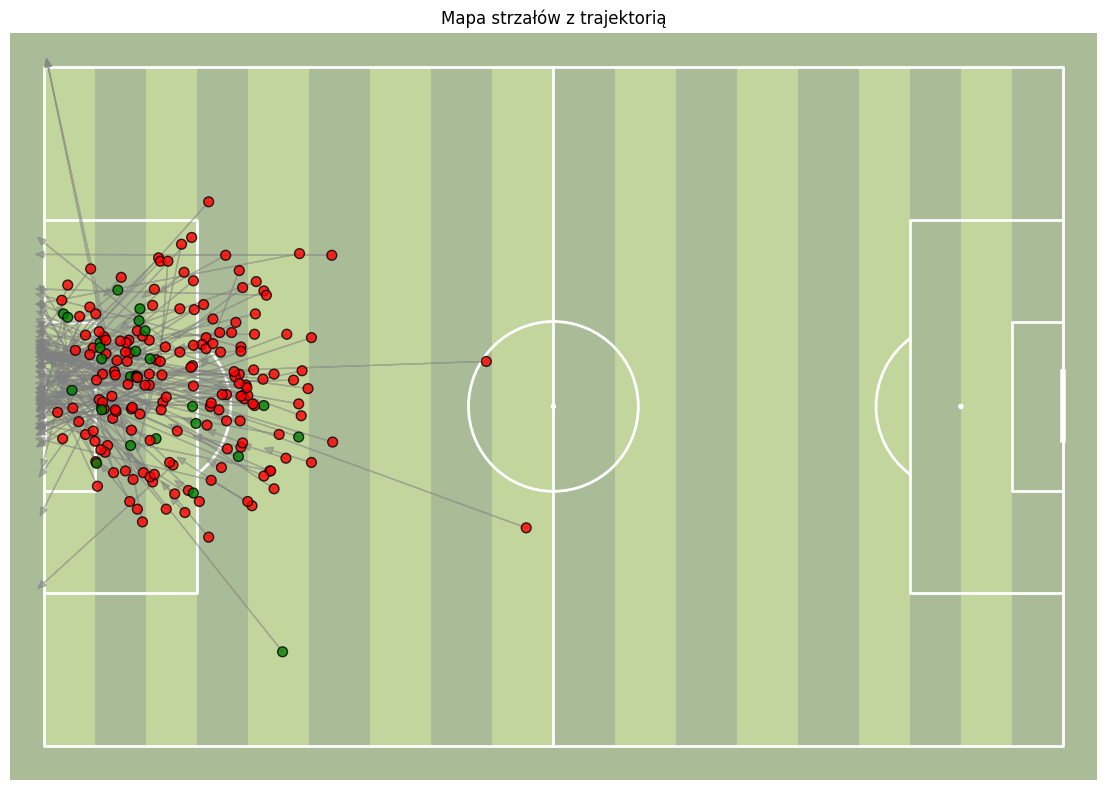

In [9]:
# Przyjmijmy, że chcesz pokazać np. 500 losowych strzałów:
sample_df = df.sample(n=200, random_state=42)

fig, ax = pitch.draw(figsize=(12, 8))
for _, row in sample_df.iterrows():
    # Rysujemy strzałkę od (x1, y1) do (x1_end, y1_end)
    ax.arrow(row['x1'], row['y1'], 
             row['x1_end'] - row['x1'], row['y1_end'] - row['y1'],
             head_width=0.8, head_length=1.0, fc='gray', ec='gray', alpha=0.5, zorder=4)

# Rysujemy punkty tak jak wcześniej:
ax.scatter(sample_df['x1'], sample_df['y1'], 
           c=sample_df['is_goal'].map(colors), 
           s=50,
           alpha=0.8, 
           edgecolors='black',
           zorder=5)
plt.title("Mapa strzałów z trajektorią")
plt.show()


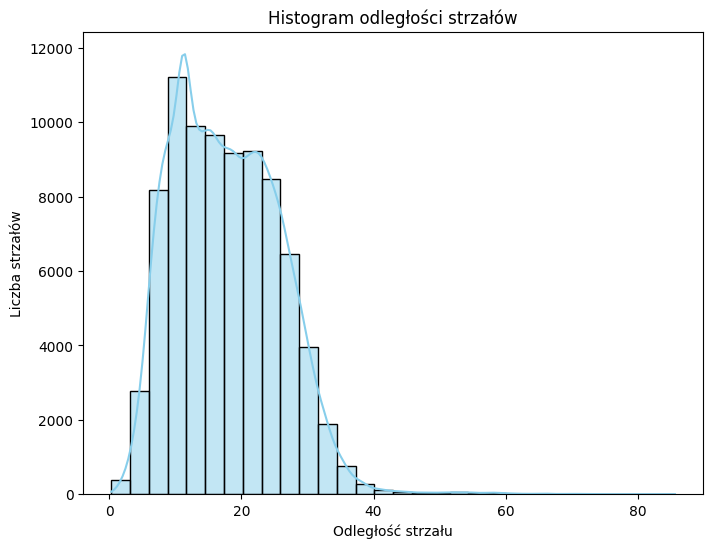

In [10]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(df['distance'], bins=30, kde=True, color='skyblue')
plt.xlabel("Odległość strzału")
plt.ylabel("Liczba strzałów")
plt.title("Histogram odległości strzałów")
plt.show()

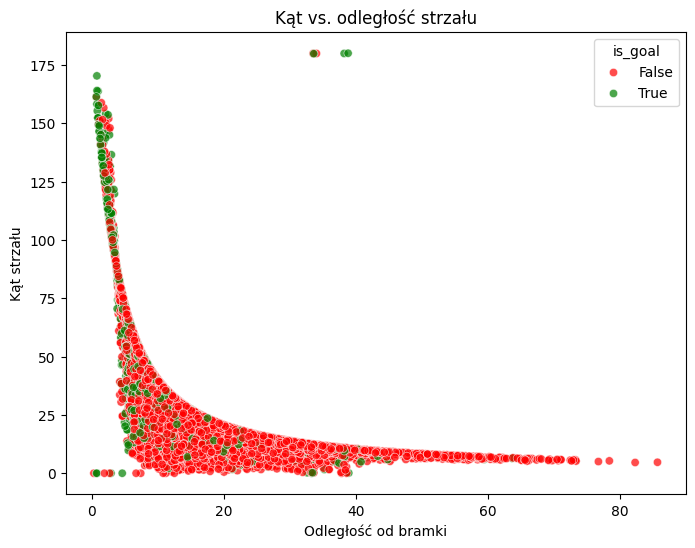

In [11]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='distance', y='angle', hue='is_goal', palette=colors, alpha=0.7)
plt.xlabel("Odległość od bramki")
plt.ylabel("Kąt strzału")
plt.title("Kąt vs. odległość strzału")
plt.show()

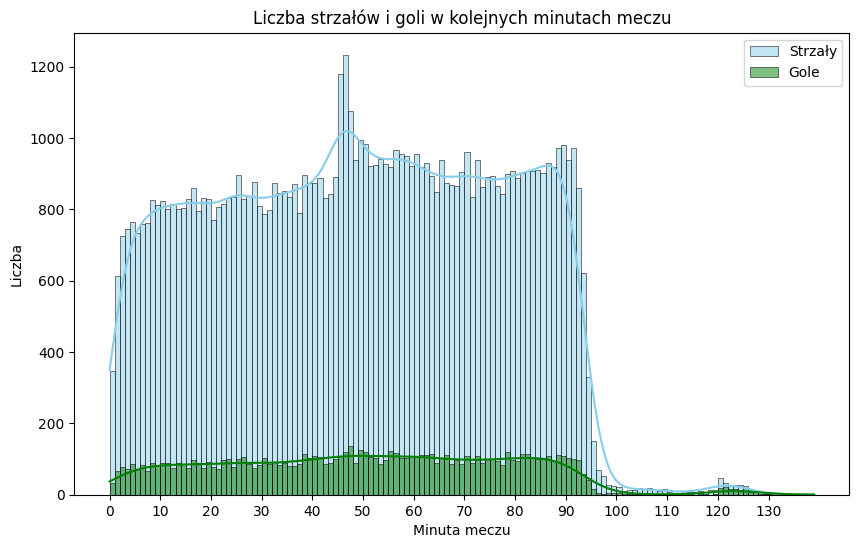

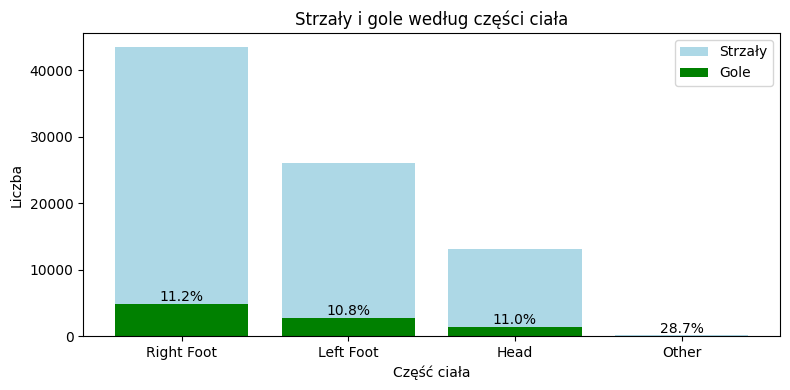

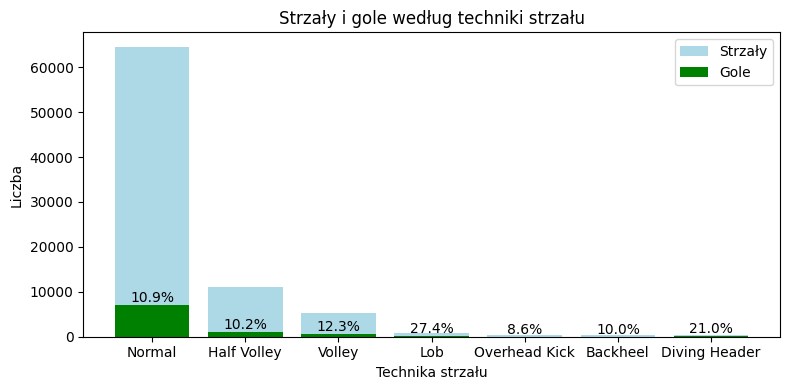

In [27]:
plt.figure(figsize=(10, 6))

# Ustalamy zakres minut na podstawie maksymalnej wartości w kolumnie minute
max_minute = df['minute'].max()
# Dla celów wizualnych ustawiamy biny co 1 minutę – etykiety osi ustawimy co 10 minut
bins = np.arange(0, max_minute + 1, 1)

# (1) Histogram i krzywa gęstości dla wszystkich strzałów (słupki w kolorze skyblue)
sns.histplot(data=df, x='minute', bins=bins, color='skyblue', 
             kde=True, stat='count', alpha=0.5, label='Strzały')

# (2) Histogram i krzywa gęstości dla goli (tylko wiersze, gdzie is_goal jest True) – słupki w kolorze zielonym
sns.histplot(data=df[df['is_goal']==True], x='minute', bins=bins, color='green', 
             kde=True, stat='count', alpha=0.5, label='Gole')

plt.title('Liczba strzałów i goli w kolejnych minutach meczu')
plt.xlabel('Minuta meczu')
plt.ylabel('Liczba')
# Ustawienie oznaczeń osi X co 10 minut
plt.xticks(np.arange(0, max_minute + 1, 10))
plt.legend()
plt.show()

# Grupujemy dane według shot_body_part_name
df_body = df.groupby('shot_body_part_name', as_index=False).agg(
    total_shots=('is_goal', 'count'),
    goals=('is_goal', 'sum')
)
# Sortujemy dane, np. według liczby strzałów malejąco
df_body = df_body.sort_values(by='total_shots', ascending=False)

plt.figure(figsize=(8, 4))
x = np.arange(len(df_body))  # pozycje na osi X

# Rysujemy słupki dla wszystkich strzałów (tło)
bar_total = plt.bar(x, df_body['total_shots'], color='lightblue', label='Strzały')

# Rysujemy nałożone słupki dla goli – pobieramy kontener słupków
bar_goals = plt.bar(x, df_body['goals'], color='green', label='Gole')

plt.xticks(x, df_body['shot_body_part_name'], rotation=0)
plt.xlabel('Część ciała')
plt.ylabel('Liczba')
plt.title('Strzały i gole według części ciała')
plt.legend()

# Dodajemy adnotacje – procentowy udział goli nad zielonym słupkiem
for rect, (_, row) in zip(bar_goals, df_body.iterrows()):
    height = rect.get_height()
    # Pozycja pozioma: środek słupka
    x_center = rect.get_x() + rect.get_width() / 2
    # Obliczamy procentowy udział goli
    percent = (row['goals'] / row['total_shots']) * 100
    # Umieszczamy tekst tuż nad zielonym słupkiem
    plt.text(x_center, height + 0.5, f'{percent:.1f}%', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

# Grupujemy dane według shot_technique_name
df_tech = df.groupby('shot_technique_name', as_index=False).agg(
    total_shots=('is_goal', 'count'),
    goals=('is_goal', 'sum')
)
# Sortujemy według liczby strzałów
df_tech = df_tech.sort_values(by='total_shots', ascending=False)

plt.figure(figsize=(8, 4))
x = np.arange(len(df_tech))

bar_total = plt.bar(x, df_tech['total_shots'], color='lightblue', label='Strzały')
bar_goals = plt.bar(x, df_tech['goals'], color='green', label='Gole')

plt.xticks(x, df_tech['shot_technique_name'], rotation=0)
plt.xlabel('Technika strzału')
plt.ylabel('Liczba')
plt.title('Strzały i gole według techniki strzału')
plt.legend()

for rect, (_, row) in zip(bar_goals, df_tech.iterrows()):
    height = rect.get_height()
    x_center = rect.get_x() + rect.get_width() / 2
    percent = (row['goals'] / row['total_shots']) * 100
    plt.text(x_center, height + 0.5, f'{percent:.1f}%', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

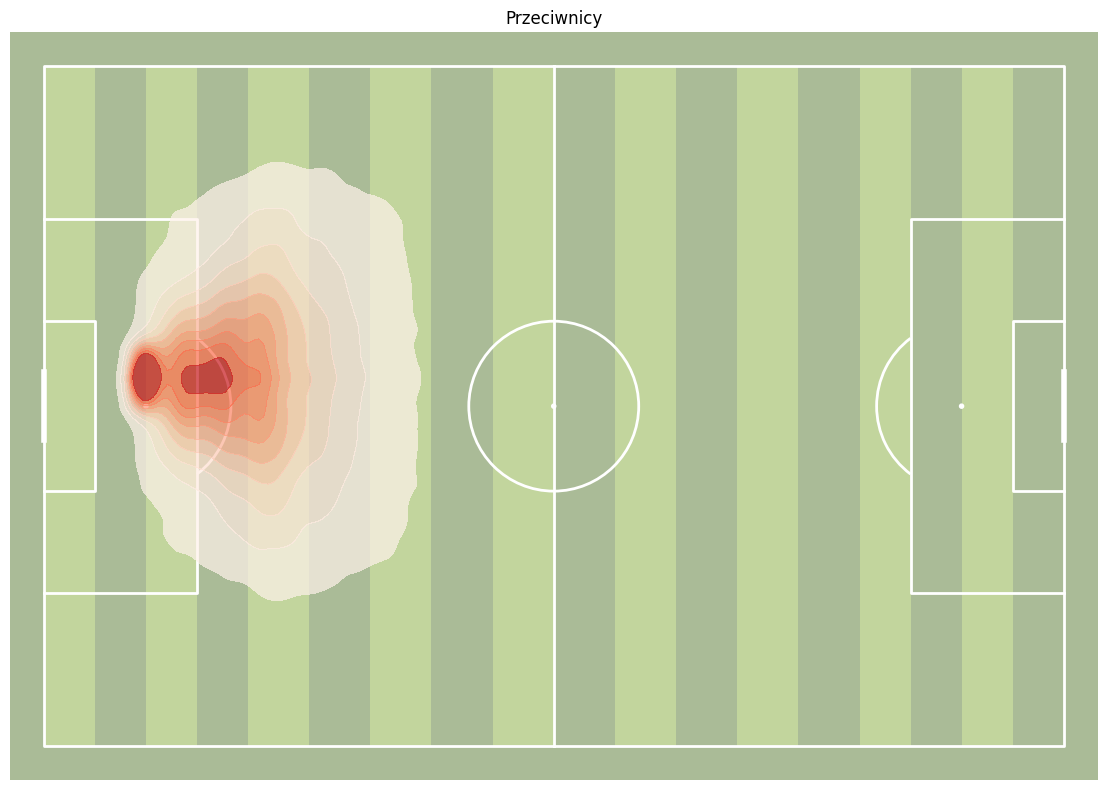

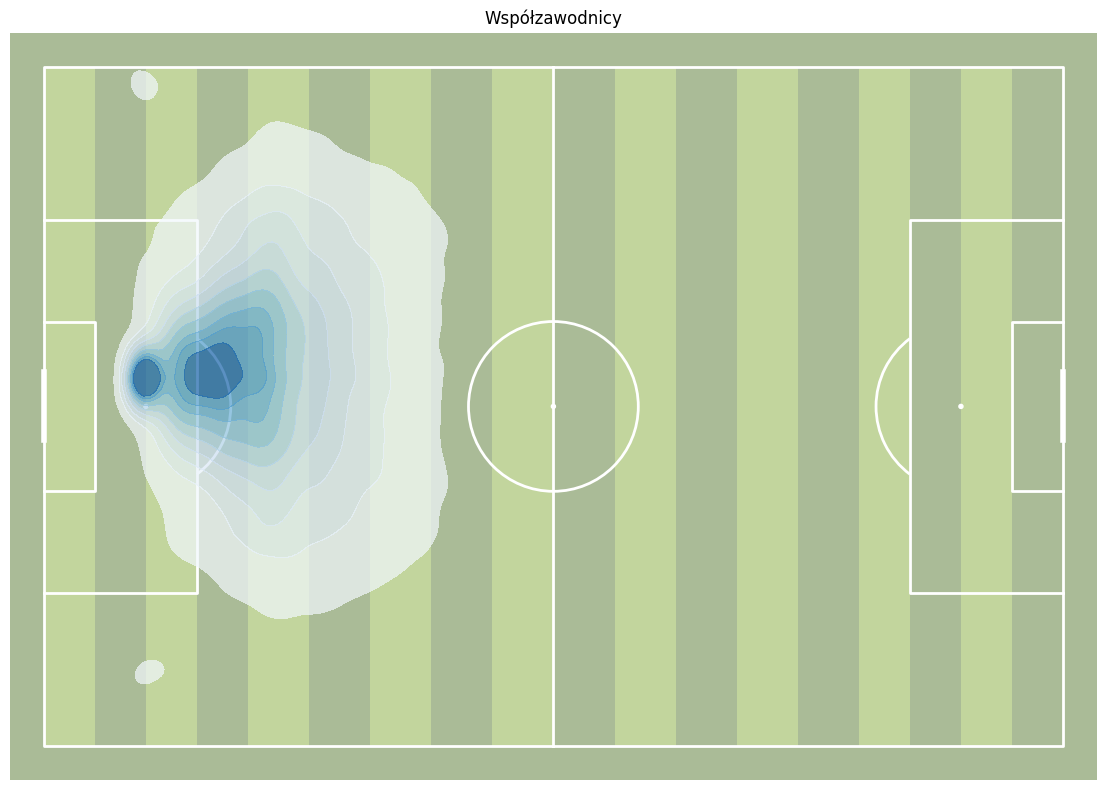

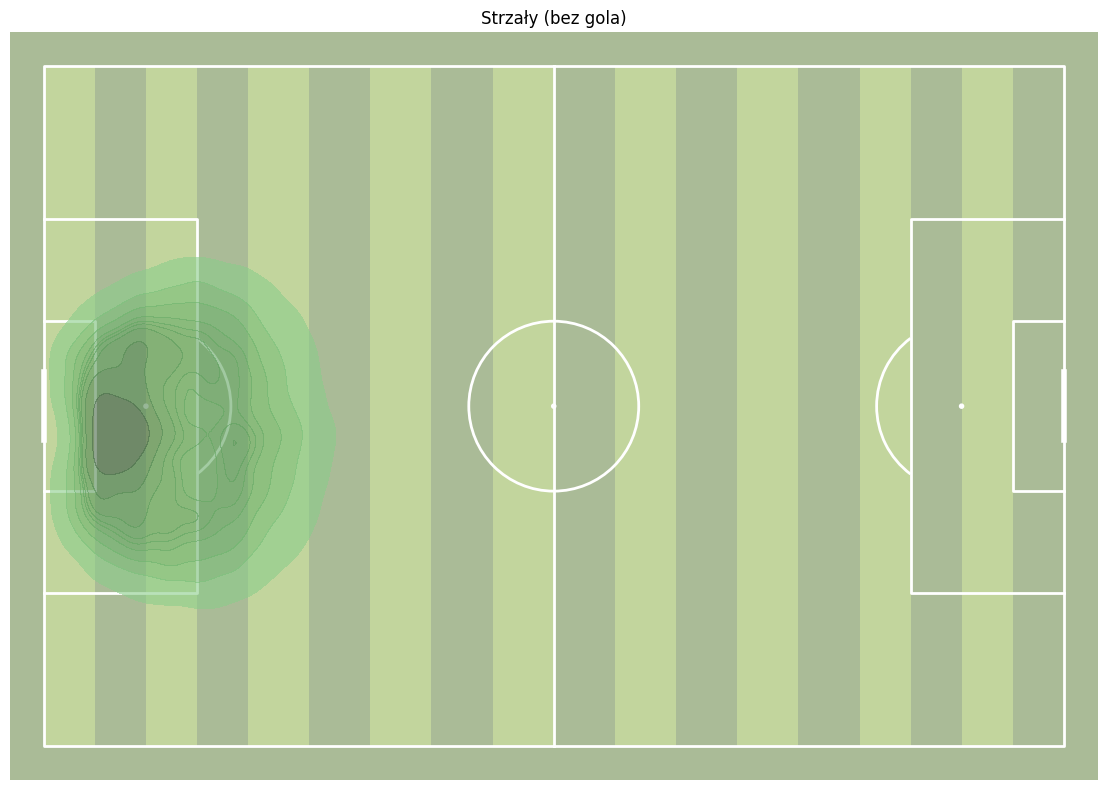

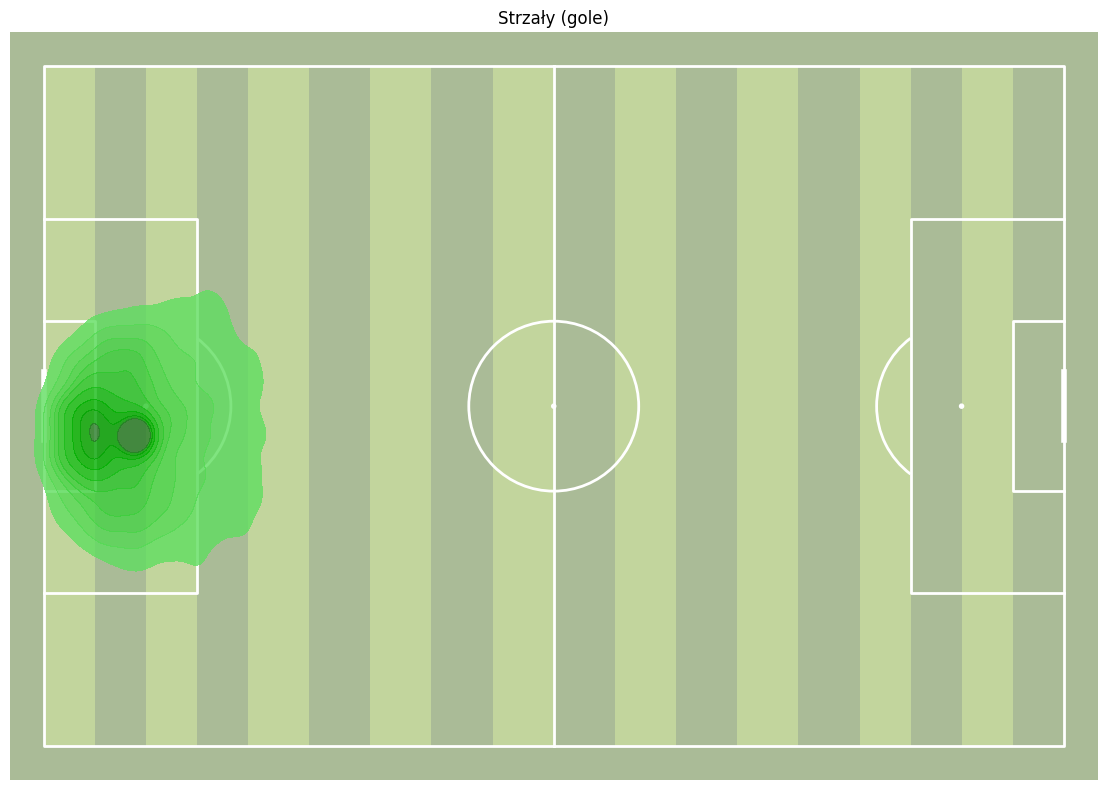

In [38]:
# --- Agregacja pozycji przeciwników ---
opponent_x_cols = [col for col in df.columns if col.startswith('x_player_opponent')]
opponent_positions = []
for x_col in opponent_x_cols:
    suffix = x_col.replace("x_player_opponent_", "")
    y_col = "y_player_opponent_" + suffix
    if y_col in df.columns:
        tmp = df[[x_col, y_col]].dropna()
        if not tmp.empty:
            tmp = tmp.rename(columns={x_col: "x", y_col: "y"})
            opponent_positions.append(tmp)
if opponent_positions:
    df_opponents = pd.concat(opponent_positions, ignore_index=True)
else:
    df_opponents = pd.DataFrame(columns=["x", "y"])

# --- Agregacja pozycji teammatów ---
teammate_x_cols = [col for col in df.columns if col.startswith('x_player_teammate')]
teammate_positions = []
for x_col in teammate_x_cols:
    suffix = x_col.replace("x_player_teammate_", "")
    y_col = "y_player_teammate_" + suffix
    if y_col in df.columns:
        tmp = df[[x_col, y_col]].dropna()
        if not tmp.empty:
            tmp = tmp.rename(columns={x_col: "x", y_col: "y"})
            teammate_positions.append(tmp)
if teammate_positions:
    df_teammates = pd.concat(teammate_positions, ignore_index=True)
else:
    df_teammates = pd.DataFrame(columns=["x", "y"])

# Tworzymy obiekt Pitch – rysujący pełne boisko
pitch = Pitch(pitch_color='#aabb97', line_color='white', stripe=True)

# ---------------------------
# Wykres 1: Pozycje przeciwników
# ---------------------------
fig1, ax1 = plt.subplots(figsize=(12, 8))
pitch.draw(ax=ax1)  # Rysujemy pełne boisko
sns.kdeplot(data=df_opponents, x='x', y='y', fill=True, cmap='Reds',
            thresh=0.05, alpha=0.7, ax=ax1)
ax1.set_title("Przeciwnicy")
ax1.invert_yaxis()  # Odwracamy oś Y, aby lepiej oddać układ boiska
plt.tight_layout()
plt.show()

# ---------------------------
# Wykres 2: Pozycje współzawodników (teammaci)
# ---------------------------
fig2, ax2 = plt.subplots(figsize=(12, 8))
pitch.draw(ax=ax2)
sns.kdeplot(data=df_teammates, x='x', y='y', fill=True, cmap='Blues',
            thresh=0.05, alpha=0.7, ax=ax2)
ax2.set_title("Współzawodnicy")
ax2.invert_yaxis()
plt.tight_layout()
plt.show()

# ---------------------------
# Wykres 3: Strzały (bez gola)
# ---------------------------
fig3, ax3 = plt.subplots(figsize=(12, 8))
pitch.draw(ax=ax3)
sns.kdeplot(data=df_shots_no_goals, x='x', y='y', fill=True, color="lightgreen",
            thresh=0.05, alpha=0.6, ax=ax3)
ax3.set_title("Strzały (bez gola)")
ax3.invert_yaxis()
plt.tight_layout()
plt.show()

# ---------------------------
# Wykres 4: Strzały (gole)
# ---------------------------
fig4, ax4 = plt.subplots(figsize=(12, 8))
pitch.draw(ax=ax4)
sns.kdeplot(data=df_shots_goals, x='x', y='y', fill=True, color="darkgreen",
            thresh=0.05, alpha=0.8, ax=ax4)
ax4.set_title("Strzały (gole)")
ax4.invert_yaxis()
plt.tight_layout()
plt.show()
